# Preprocessing

### Import file and load data

In [1]:
# import libraries
import glob  # glob function in glob module returns corresponding file names as list
import tensorflow as tf
import os, re 
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# load file as raw data
# '.getenv()' function returns string variable of all file in the path by adding '*' as arg
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path) # return all file names as list type

raw_corpus = [] 

# assign all txt files and add it to raw_corpus
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() # read() : bring data in a file to a single string.
                                    # splitlines()  : split multi-line strings into single line list
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


### Regex (Regular Expression)

In [3]:
#     1. lowercase all letters and remove blank space
#     2. add blank space on both sides of special characters
#     3. change multiple blank spaces into single space
#     4. If not, a-zA-Z?.!,¿ change to single space
#     5. remove blank space
#     6. add <start> at the start of the sentence and <end> at the end
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# printing sample sentence
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


**Process of above cell (Regex) is similar to tensorflow "Tokenizer or TextVectorization filtering"**

In [4]:
# Adding preprocessed sentences to a variable corpus
corpus = []

# Retrieve elements from raw_corpus list
for sentence in raw_corpus:
    # Skipping unwanted sentence
    if len(sentence) == 0: continue   # skip if blank
    if sentence[-1] == ":": continue  # skip if sentence ends with :
        
    # use preprocess_sentence() function, transform sentence, and add them to corpus if less than 15
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split(" ")) > 15: continue
        
    corpus.append(preprocessed_sentence)
        
# quick check of first 10 elements from corpus
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

**Process of above cell (picking out less than 15 words) is similar to tf.keras.preprocessing.sequence.pad_sequences(max_len)**

In [5]:
# cross-checking whether corpus contains lines that are less than 15 or not
for i in corpus:
    if len(i.split()) > 15:
        print(i)

# Tokenizing

In [6]:
# Using Tokenizer and pad_sequences from tensorflow to break each element into tokens
# Refer to below addresses for further info.
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, # set num of words to tokenize
        filters=' ', # already filtered via preprocess_sentence function, hence ' ' to not use filter param
        oov_token="<unk>" # any words after 12000, turn them into '<unk>'
    )
    # creating tokenizer vocab from corpus
    # tokenizer.fit_on_texts(texts): return string data into a list
    tokenizer.fit_on_texts(corpus)
    
    # transform corpus into tensor using tokenizer
    # tokenizer.texts_to_sequences(texts): return texts into num sequence
    tensor = tokenizer.texts_to_sequences(corpus)   
    # equalizing the length of input data sequence
    # add padding after each line if the length is not 15
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    # can use parameter maxlen to limit the length of a sentence
    
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)
tensor.shape

(156013, 15)

In [7]:
# tokenizer.index_word: return dict of vocab (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [8]:
# slice til last element of tensor as source input, which most likely will be <pad> not <end>
src_input = tensor[:, :-1]  
# target input will be anything after slicing <start> from tensor
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])
print(len(src_input[0]))
print(len(tgt_input[0]))
print(len(src_input))
print(src_input.shape)

[   2   50    4   95  303   62   53    9  946 6263    3    0    0    0]
[  50    4   95  303   62   53    9  946 6263    3    0    0    0    0]
14
14
156013
(156013, 14)


In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer vocab = 12000 + 1 = 12001. Vocab size + 0:<pad>, which is equivalent to 12001
# tokenizer.num_words: words based on 'n' frequency
# tokenize() param of num_words = 12000 = tokenizer.num_words = 12000
VOCAB_SIZE = tokenizer.num_words + 1   

# Making dataset from prepped data source
# Refer to below address for dataset (important)
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [10]:
# splitting data into train and test sets
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2)
print(enc_train.shape, enc_val.shape, dec_train.shape, dec_val.shape)

(124810, 14) (31203, 14) (124810, 14) (31203, 14)


# Building a model

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Consists of embedding layer, 2 LSTM layers, and 1 Dense layer
        # Embedding layer changes vocab index value to corresponding index word vector
        # this word vector is used as an abstract representation in definition of vector space
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# higher embedding size can pinpoint more abstract representation
# but can lead to worse result if not enough data
embedding_size = 256 # word vector dimension, size of abstract representation of the word
hidden_size = 1024 # similar to how many workers you want to station
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)
# tokenizer.num_words +1 is due to using <pad> which is not in the vocab

### Training and testing a model

In [12]:
# Refer to below addresses for optimizers and losses
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses

# If unsure, which optimizer to use, choosing Adam can be a way
# Need to train to reduce loss (loss/cost function)
# Training to find a minimal value of loss function is the goal and process of finding it is optimization
# optimizer is an algorithm of finding it

optimizer = tf.keras.optimizers.Adam()

# tf.keras.losses.SparseCategoricalCrossentropy
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none') 
# In classification, if using softmax, then param from_logits = False(default값), otherwise from_logits = True.

# Steps to set up and train a model
model.compile(loss=loss, optimizer=optimizer) # Setting loss function and optimizer
model.fit(dataset, epochs=10, validation_data=(enc_val, dec_val))

Epoch 1/10
609/609 [==============================] - 115s 178ms/step - loss: 3.4242 - val_loss: 3.0660
Epoch 2/10
609/609 [==============================] - 119s 195ms/step - loss: 2.9749 - val_loss: 2.8536
Epoch 3/10
609/609 [==============================] - 123s 201ms/step - loss: 2.8049 - val_loss: 2.7060
Epoch 4/10
609/609 [==============================] - 123s 201ms/step - loss: 2.6775 - val_loss: 2.5864
Epoch 5/10
609/609 [==============================] - 123s 201ms/step - loss: 2.5685 - val_loss: 2.4840
Epoch 6/10
609/609 [==============================] - 123s 201ms/step - loss: 2.4710 - val_loss: 2.3845
Epoch 7/10
609/609 [==============================] - 123s 201ms/step - loss: 2.3799 - val_loss: 2.2931
Epoch 8/10
609/609 [==============================] - 123s 201ms/step - loss: 2.2945 - val_loss: 2.2109
Epoch 9/10
609/609 [==============================] - 123s 201ms/step - loss: 2.2147 - val_loss: 2.1314
Epoch 10/10
609/609 [==============================] - 123s 201m

In [13]:
# summary of a model
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Creating generate_text function
# Deliver <start> + alpha(if applicable) and the model will write/compose
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    
    # for testing purposes, changing init_sentence as tensor
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # predict next word one by one to make a sentence
    #    1. input received word's tensor
    #    2. retrieve word index with the highest probability
    #    3. concatenate predicted word index from step 2
    #    4. if the model predicts <end> or reaches max_len, exit while loop
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # use tokenizer to change word index back into human words
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated # return sentence

In [15]:
lyricist = model

# with generate_text function, return a sentence after love
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , liberian girl <end> '

# 회고

어려웠던 점은 프로젝트를 자세하게 이해하는 것이 힘들다는 것 이었다.

텐서플로우를 이용해 모델 만드는 방법도 아직 서툴고 큰 흐름을 알지 못한채 이 프로젝트를 진행하려고 했다면 엄청나게 많은 시간이 필요했을 것 같다.

다행히 코드를 작성하고 주석을 달면서 조금씩이나마 이해를 하기 시작했다는게 긍적적이었다.

이번에 전처리 과정에서 regex를 이용해 문장을 미리 전처리 하고 문장 크기를 줄이는 과정이 있었다.

예전에 regex를 배울땐 많이 사용해보지 못하여 이해하기가 어려웠는데, 다시 사용해보는 과정이 있어서 도움이 많이 됐다.

더 쉽게 regex와 문장 수를 줄이는 방법을 찾다가 텐서플로우에 Tokenizer안에 filtering와 pad_sequence안에 maxlen 파라미터를 이용하여 가능하다는 것을 새롭게 알게 됐다.

새로 해봤던 점은 pad_sequence에서 문장이 15개 이하일 때 0으로 패딩을 추가하는 방식에서 'post'로 해봤었는데, 이번에는 'pre'로 해봤다.

다만 'pre'를 사용했을 때, 같은 hyperparameter값으로 실험을 진행했을 때, loss 값이 기대치보다 높게 나왔다. 그리고 문장 자체는 더 길게 나왔지만 살짝 이상하게 나왔다.


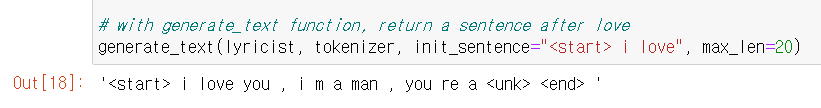


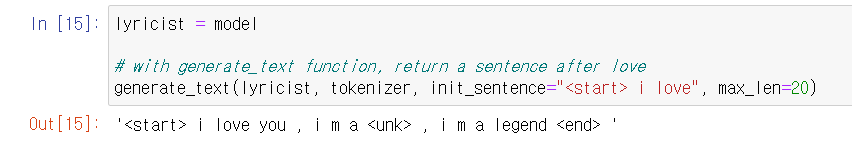


이유를 찾아보니, padding은 앞에 붙으면 뒤에 더 중요성이 있고, 뒤에 붙으면 앞에 더 중요성을 두고 학습하는 과정인데, 이 작사가 프로젝트의 input과 output의 형태가 many-to-many여서 (선중님 한테 들음) 처음 값의 결과로 다음 값을 계속 이어나가며 문장을 만든다.

그렇기에 이번 프로젝트에선 padding을 post로 해서 학습해야 한다는 점도 배웠다.

#### 더 배워야 할점
- tensorflow dataset details
- model building spec